https://github.com/pytorch/examples/blob/master/mnist/main.py

In [1]:
from torchvision import datasets, transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor()])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
print(dataset1)
print("------------------")
dataset2 = datasets.MNIST('./data', train=False, download=True, transform=transform)
print(dataset2)
print("------------------")
print(dir(dataset1))

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
------------------
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
------------------
['__add__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_format_transform_repr', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_lab

In [3]:
print("data count:", len(dataset1.data))
print("test data count:", len(dataset1.test_data))
print("train data count:", len(dataset1.train_data))
print("train label count:", dataset1.train_labels)
print(dataset1.classes)
print("============ test set =============")
print("data count:", len(dataset2.data))
print("test data count:", len(dataset2.test_data))
print("train data count:", len(dataset2.train_data))
print("train label count:", dataset2.train_labels)
print(dataset1.classes)


data count: 60000
test data count: 60000
train data count: 60000
train label count: tensor([5, 0, 4,  ..., 5, 6, 8])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
============ test set =============
data count: 10000
test data count: 10000
train data count: 10000
train label count: tensor([7, 2, 1,  ..., 4, 5, 6])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
import matplotlib.pyplot as plt

tensor(6)


torch.Size([28, 28])

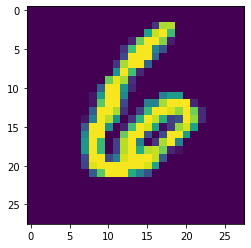

In [5]:

print(dataset1.train_labels[13])
plt.imshow(dataset1.data[13])
dataset1.data[13].size()

In [6]:
import torch;
import torch.nn as nn;
import torch.nn.functional as F

In [44]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        # self.conv2 = nn.Conv2d(32,64,3,1)
        self.fc1 = nn.Linear(5408, 128) # 9216
        self.fc2 = nn.Linear(128, 10)

        # self.fc1b = nn.Linear(784, 512)
        # self.fc2b = nn.Linear(512, 256)
        # self.fc3b = nn.Linear(256, 128)
        # self.fc4b = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.conv2(x)
        # x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        # x = torch.flatten(x, 1)
        # x = self.fc1b(x)
        # x = F.relu(x)
        # x = self.fc2b(x)
        # x = F.relu(x)
        # x = self.fc3b(x)
        # x = F.relu(x)
        # x = self.fc4b(x)
        # output = F.log_softmax(x, dim=1)
        return output

device = torch.device("cpu")
torch.manual_seed(1)
model = Net().to(device)

import torch.optim as optim
optimizer = optim.Adadelta(model.parameters(), 1)
for param in model.parameters():  
    print(type(param), param.size())


<class 'torch.nn.parameter.Parameter'> torch.Size([32, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 5408])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 128])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])


In [45]:
from torch.optim.lr_scheduler import StepLR

test_losses = []
accuracies = []
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=64)
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
    
    test_losses.append(test_loss)
    accuracies.append(correct / len(test_loader.dataset))
    print("Test Set Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

# execute code
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
for epoch in range(1, 14):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100.*batch_idx / len(train_loader), loss.item()))
    test()
    scheduler.step() # end of epoch
print("# DONE!")
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309939
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.308255
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.206578
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.274846
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.084945
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.169498
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.099640
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.144300
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.123083
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124712
Test Set Average loss: 0.0726, Accuracy: 9770 / 10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.036532
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.112657
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.062733
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.109863
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.023699
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.099917
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.114941
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.081811
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.087933
T

In [27]:
def draw_result(accuracies, test_losses):
    x = list(range(len(accuracies)))
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy', color=color)
    ax1.plot(x, accuracies, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)
    ax2.plot(x, test_losses, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.show()

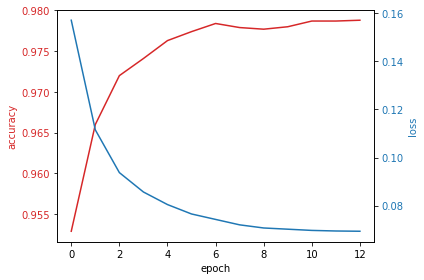

In [30]:
# x = torch.flatten(x, 1)
# x = self.fc1b(x) # self.fc1b = nn.Linear(784, 128)
# x = F.relu(x)
# x = self.fc4b(x) # self.fc4b = nn.Linear(128, 10)
# output = F.log_softmax(x, dim=1)
accuracies = [0.9529, 0.966, 0.972, 0.9741, 0.9763, 0.9774, 0.9784, 0.9779, 0.9777, 0.978, 0.9787, 0.9787, 0.9788]
test_losses = [0.15712404657006263, 0.11151853018179536, 0.09373190107196569, 0.0856703475765884, 0.08043483061091974, 0.0765213711163029, 0.07425679129869678, 0.07199820835611317, 0.07069607834117488, 0.0701904908586177, 0.06968474492724054, 0.06944236495944787, 0.06933620982736466]
draw_result(accuracies, test_losses)

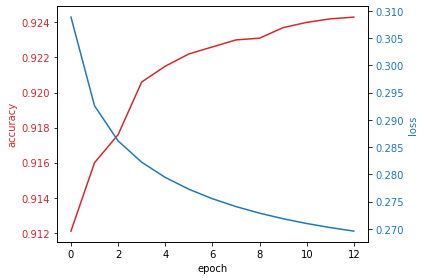

In [28]:
# x = torch.flatten(x, 1)
# x = self.fc1b(x) # self.fc1b = nn.Linear(784, 10)
# output = F.log_softmax(x, dim=1)
accuracies = [0.9121, 0.916, 0.9176, 0.9206, 0.9215, 0.9222, 0.9226, 0.923, 0.9231, 0.9237, 0.924, 0.9242, 0.9243]
test_losses = [0.3088285360813141, 0.29257425411343574, 0.2861253346443176, 0.28222684099078177, 0.27943418153524396, 0.27727121294140816, 0.27552673637270925, 0.2740863732933998, 0.2728789205491543, 0.27185601385235786, 0.2709828985095024, 0.2702338867485523, 0.26958956956863406]
draw_result(accuracies, test_losses)

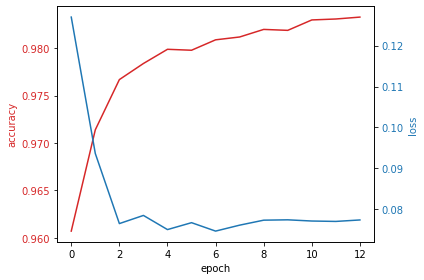

In [29]:
# x = torch.flatten(x, 1)
# x = self.fc1b(x) # self.fc1b = nn.Linear(784, 512)
# x = F.relu(x)
# x = self.fc2b(x) # self.fc2b = nn.Linear(512, 128)
# x = F.relu(x)
# x = self.fc3b(x) # self.fc3b = nn.Linear(128, 10)
# output = F.log_softmax(x, dim=1)
accuracies = [0.9607, 0.9714, 0.9767, 0.9784, 0.9799, 0.9798, 0.9809, 0.9812, 0.982, 0.9819, 0.983, 0.9831, 0.9833]
test_losses = [0.1269788561567664, 0.09362588681392371, 0.0765121658733813, 0.07850383437901619, 0.07504620076880819, 0.07673383349170908, 0.07467501490372506, 0.07612792177460916, 0.07734604125622509, 0.07743191612226319, 0.07713756980401365, 0.07704066612588276, 0.07739828828455815]
draw_result(accuracies, test_losses)

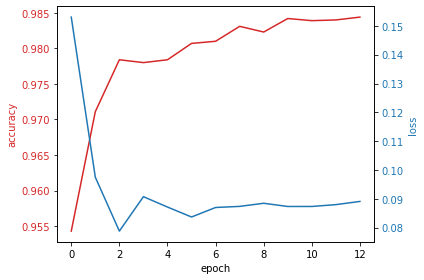

In [34]:
# x = torch.flatten(x, 1)
# x = self.fc1b(x) # self.fc1b = nn.Linear(784, 512)
# x = F.relu(x)
# x = self.fc2b(x) # self.fc2b = nn.Linear(512, 256)
# x = F.relu(x)
# x = self.fc3b(x) # self.fc3b = nn.Linear(256, 128)
# x = F.relu(x)
# x = self.fc4b(x) # self.fc4b = nn.Linear(128, 10)
# output = F.log_softmax(x, dim=1)
accuracies = [0.9543, 0.9711, 0.9784, 0.978, 0.9784, 0.9807, 0.981, 0.9831, 0.9823, 0.9842, 0.9839, 0.984, 0.9844]
test_losses = [0.15305172763168812, 0.09746764089018106, 0.07876170394318179, 0.0907085024118307, 0.08711440434336545, 0.0836560793912533, 0.08695711482001661, 0.08734180262991471, 0.08842390272379011, 0.08730717940288459, 0.08731357793352436, 0.08795041901732796, 0.08906095247713533]
draw_result(accuracies, test_losses)

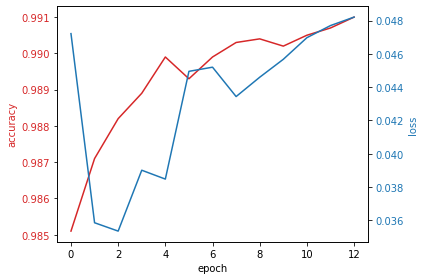

In [39]:
# x = self.conv1(x) # self.conv1 = nn.Conv2d(1,32,3,1)
# x = F.relu(x)
# x = self.conv2(x) # self.conv2 = nn.Conv2d(32,64,3,1)
# x = F.relu(x)
# x = F.max_pool2d(x, 2)
# x = torch.flatten(x, 1)
# x = self.fc1(x) # self.fc1 = nn.Linear(9216, 128)
# x = F.relu(x)
# x = self.fc2(x) # self.fc2 = nn.Linear(128, 10)
# output = F.log_softmax(x, dim=1)

accuracies = [0.9851, 0.9871, 0.9882, 0.9889, 0.9899, 0.9893, 0.9899, 0.9903, 0.9904, 0.9902, 0.9905, 0.9907, 0.991]
test_losses = [0.04721645657196641, 0.035854716578917575, 0.03535289466709946, 0.0390101311866405, 0.03847765199488749, 0.04495046339283121, 0.0452004008872491, 0.04343579486534756, 0.044596330870040404, 0.045673628931332935, 0.04697256963628634, 0.04770014912321419, 0.04820923449445504]
draw_result(accuracies, test_losses)

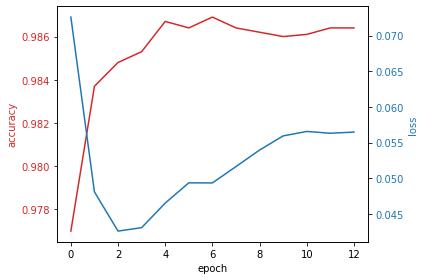

In [47]:
# x = self.conv1(x) # self.conv1 = nn.Conv2d(1,32,3,1)
# x = F.relu(x)
# x = F.max_pool2d(x, 2)
# x = torch.flatten(x, 1)
# x = self.fc1(x) # self.fc1 = nn.Linear(5408, 128)
# x = F.relu(x)
# x = self.fc2(x) # self.fc2 = nn.Linear(128, 10)
# output = F.log_softmax(x, dim=1)
accuracies = [0.977, 0.9837, 0.9848, 0.9853, 0.9867, 0.9864, 0.9869, 0.9864, 0.9862, 0.986, 0.9861, 0.9864, 0.9864]
test_losses = [0.07259480738416314, 0.04810611624820158, 0.042615457174507904, 0.04309643292617984, 0.046537509947159564, 0.049376684566889886, 0.04936440078333617, 0.05165633166161642, 0.05396991287453638, 0.05595312938646821, 0.05657379835692791, 0.056323058967966244, 0.056487265960761576]
draw_result(accuracies, test_losses)